### Imports


In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import losses

import numpy as np
import matplotlib.pyplot as plt


Num GPUs Available:  0


### Preparing Data

In [2]:
from tensorflow.keras.datasets import mnist
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

In [3]:
X_train_full = X_train_full.reshape((60000,-1))
X_test_full = X_test_full.reshape((10000,-1))

In [4]:
X_train = np.zeros((1000,784))
X_test = np.zeros((1000,784))
y_train = np.zeros((1000), dtype = int)
y_test = np.zeros((1000), dtype = int)

In [5]:
classes = np.arange(10)

for i in classes:

    X_i = X_train_full[y_train_full == i, :].copy()
    y_i = y_train_full[y_train_full == i] # trivial as y_i is one class

    i_100 = np.random.choice(X_i.shape[0], 100, replace = False)
    X_train[i*100: (i+1)*100,:] = X_i[i_100, :].copy()
    y_train[i*100: (i+1)*100] = y_i[i_100].copy()

    X_test_i = X_test_full[y_test_full == i, :].copy()
    y_test_i = y_test_full[y_test_full == i]

    i_100 = np.random.choice(X_test_i.shape[0], 100, replace = False)

    X_test[i*100: (i+1)*100,:] = X_test_i[i_100, :].copy()
    y_test[i*100: (i+1)*100] = y_test_i[i_100].copy()


In [6]:
## Normalizing

X_train_normal = X_train /255
X_test_normal  = X_test  /255

In [7]:
### Creating tf datasets
batch_size = 10
train_ds = tf.data.Dataset.from_tensor_slices((X_train_normal, y_train)).shuffle(1000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_normal, y_test)).shuffle(1000).batch(batch_size)

### Util Functions

In [10]:
def get_weight_sum(weights):
    weight_sum = 0
    for weight in weights:
        weight_sum += np.absolute(weight).sum()
  
    return float(weight_sum) / len(weights)

def get_weight_difference(weights1, weights2):

    absolute_difference = 0

    for i in range(len(weights1)):

        diff = weights1[i] - weights2[i]
        diff_sum = np.absolute(diff).sum()
        absolute_difference += diff_sum
  
    return float(absolute_difference) / len(weights1)


def train(model, epochs):
    
    steps_per_epoch = np.ceil(X_train_normal.shape[0]/batch_size)
    train_losses = []
    test_losses  = []
    train_errors  = []
    test_errors  = []
    learning_speeds = []

    last_weights = model.get_weights()

    for i in range(epochs):
        print('Epoch {}:'.format(i+1))
        H=model.fit(train_ds, epochs=1, steps_per_epoch= steps_per_epoch,
                          validation_data = test_ds, validation_steps = steps_per_epoch)

        train_losses.append(H.history['loss'][0])
        test_losses.append(H.history['val_loss'][0])

        train_errors.append(1-H.history['sparse_categorical_accuracy'][0])
        test_errors.append(1-H.history['val_sparse_categorical_accuracy'][0])

        curr_weights = model.get_weights()
        last_weight_sum = get_weight_sum(last_weights)

        abs_weight_difference = get_weight_difference(curr_weights, last_weights)
        learning_speed = float(abs_weight_difference) / last_weight_sum
        learning_speeds.append(learning_speed)

        last_weights = curr_weights

  
    history = {}

    history['train_losses'] = train_losses
    history['test_losses'] = test_losses
    history['train_errors'] = train_errors
    history['test_errors'] = test_errors
    history['learning_speeds'] = learning_speeds
  

    return history

In [11]:
def plot_history(history, epochs):

    epochs_range = range(epochs)
    plt.figure(figsize = (8,8))

    plt.subplot(2,2,1)
    plt.plot(epochs_range, history['train_losses'], label = 'train loss')
    plt.plot(epochs_range, history['test_losses'], label = 'test loss')
    plt.legend(loc = 'upper right')
    plt.title('Train and Test Criterion Function')

    plt.subplot(2,2,2)
    plt.plot(epochs_range, history['train_errors'], label = 'train error')
    plt.plot(epochs_range, history['test_errors'], label = 'test error')
    plt.legend(loc = 'upper right')
    plt.title('Train and Test Errors')

    plt.subplot(2,2,3)
    plt.plot(epochs_range, history['learning_speeds'])
    plt.title('Learning Speed')



### Part 2a

In [12]:

learning_rate = 0.1
epochs = 30

In [13]:
model = Sequential()
model.add(Dense(30,'sigmoid', input_shape = (X_train_normal.shape[1],))) 
model.add(Dense(10, 'softmax'))
model.compile(optimizer=optimizers.Adam(learning_rate), loss=losses.SparseCategoricalCrossentropy(),
              metrics = ['sparse_categorical_accuracy'])

In [14]:
history = train(model, epochs)

Epoch 1:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 4ms/step - loss: 1.5892 - sparse_categorical_accuracy: 0.4560 - val_loss: 1.1173 - val_sparse_categorical_accuracy: 0.6190
Epoch 2:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 1.0194 - sparse_categorical_accuracy: 0.6530 - val_loss: 1.1276 - val_sparse_categorical_accuracy: 0.6200
Epoch 3:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 0.8993 - sparse_categorical_accuracy: 0.7040 - val_loss: 1.0953 - val_sparse_categorical_accuracy: 0.6210
Epoch 4:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 0.9666 - sparse_categorical_accuracy: 0.6700 - val_loss: 0.9985 - val_sparse_categorical_accuracy: 0.6690
Epoch 5:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================

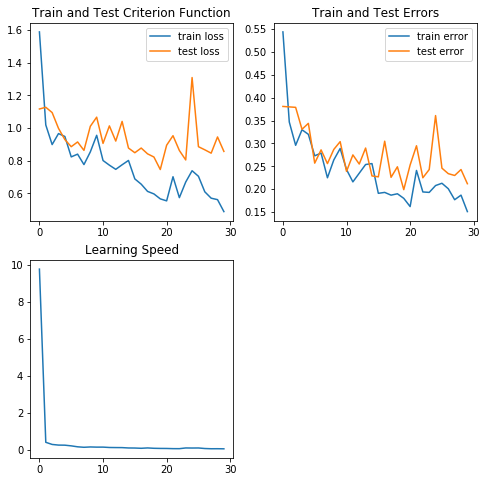

In [15]:
plot_history(history, epochs)

### Part 2b

#### Without Regularization


In [16]:
### 2 Hidden layers

learning_rate = 0.05
epochs = 30

model = Sequential()
model.add(Dense(30,'sigmoid', input_shape = (X_train_normal.shape[1],))) 
model.add(Dense(30,'sigmoid'))
model.add(Dense(10, 'softmax'))
model.compile(optimizer=optimizers.Adam(learning_rate), loss=losses.SparseCategoricalCrossentropy(),
              metrics = ['sparse_categorical_accuracy'])


In [17]:
history = train(model, epochs)

Epoch 1:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 4ms/step - loss: 1.6997 - sparse_categorical_accuracy: 0.3900 - val_loss: 1.1685 - val_sparse_categorical_accuracy: 0.6070
Epoch 2:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 0.9290 - sparse_categorical_accuracy: 0.6840 - val_loss: 0.9070 - val_sparse_categorical_accuracy: 0.6990
Epoch 3:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 0.7375 - sparse_categorical_accuracy: 0.7710 - val_loss: 0.8134 - val_sparse_categorical_accuracy: 0.7460
Epoch 4:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 0.6673 - sparse_categorical_accuracy: 0.7840 - val_loss: 0.7641 - val_sparse_categorical_accuracy: 0.7420
Epoch 5:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================

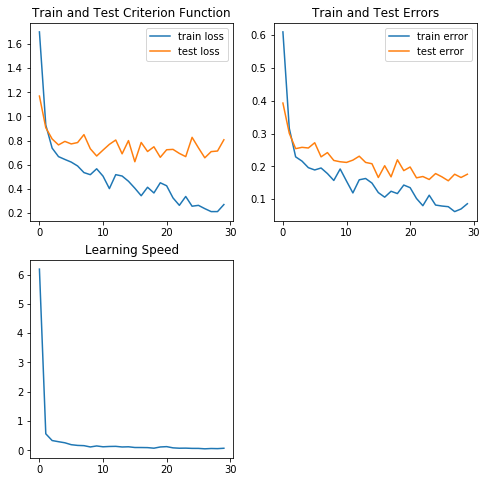

In [18]:
plot_history(history, epochs)

In [19]:
### 3 Hidden layers

learning_rate = 0.03
epochs = 30

model = Sequential()
model.add(Dense(30,'sigmoid', input_shape = (X_train.shape[1],))) 
model.add(Dense(30,'sigmoid'))
model.add(Dense(30,'sigmoid'))
model.add(Dense(10, 'softmax'))
model.compile(optimizer=optimizers.Adam(learning_rate), loss=losses.SparseCategoricalCrossentropy(),
              metrics = ['sparse_categorical_accuracy'])


In [20]:
history = train(model, epochs)

Epoch 1:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 1s 5ms/step - loss: 1.7071 - sparse_categorical_accuracy: 0.3560 - val_loss: 1.2273 - val_sparse_categorical_accuracy: 0.5450
Epoch 2:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 1.1198 - sparse_categorical_accuracy: 0.5710 - val_loss: 1.0781 - val_sparse_categorical_accuracy: 0.6040
Epoch 3:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 0.9834 - sparse_categorical_accuracy: 0.6420 - val_loss: 1.0246 - val_sparse_categorical_accuracy: 0.6550
Epoch 4:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 0.8763 - sparse_categorical_accuracy: 0.6700 - val_loss: 1.0823 - val_sparse_categorical_accuracy: 0.6590
Epoch 5:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================

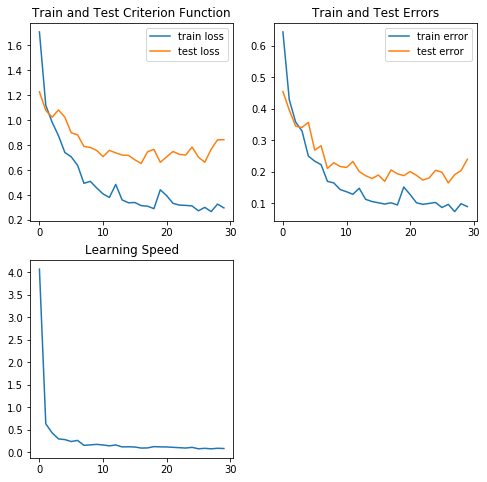

In [21]:
plot_history(history, epochs)

#### With Regularization


##### 1 hidden layer

In [25]:
## 1 hidden layer
learning_rate = 0.02
epochs = 30

model = Sequential()
model.add(Dense(30,'sigmoid', input_shape = (X_train.shape[1],), kernel_regularizer= regularizers.l2(0.005))) 
model.add(Dense(10, 'softmax'))
model.compile(optimizer=optimizers.Adam(learning_rate), loss=losses.SparseCategoricalCrossentropy(),
              metrics = ['sparse_categorical_accuracy'])

In [26]:
history = train(model, epochs)

Epoch 1:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 4ms/step - loss: 1.6073 - sparse_categorical_accuracy: 0.6420 - val_loss: 1.2822 - val_sparse_categorical_accuracy: 0.7580
Epoch 2:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 1.3233 - sparse_categorical_accuracy: 0.7500 - val_loss: 1.3078 - val_sparse_categorical_accuracy: 0.7540
Epoch 3:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 1.2809 - sparse_categorical_accuracy: 0.7280 - val_loss: 1.2219 - val_sparse_categorical_accuracy: 0.7600
Epoch 4:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 1.3612 - sparse_categorical_accuracy: 0.7420 - val_loss: 1.2804 - val_sparse_categorical_accuracy: 0.7760
Epoch 5:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================

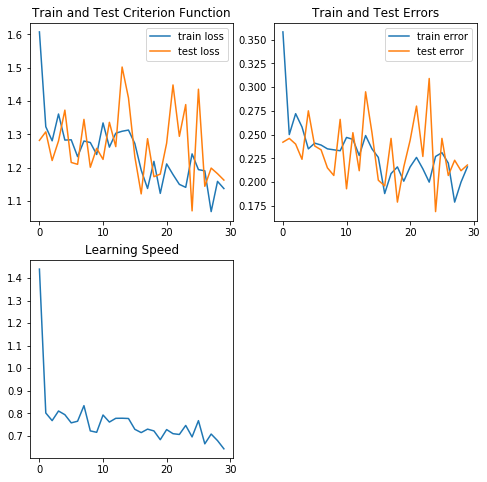

In [27]:
plot_history(history, epochs)

##### 2 hidden layers

In [28]:
## 2 hidden layers
learning_rate = 0.01
epochs = 30
lamda = 0.001  

model = Sequential()
model.add(Dense(30,'sigmoid', input_shape = (X_train.shape[1],), kernel_regularizer= regularizers.l2(lamda))) 
model.add(Dense(30,'sigmoid', kernel_regularizer= regularizers.l2(lamda))) 
model.add(Dense(10, 'softmax'))
model.compile(optimizer=optimizers.Adam(learning_rate), loss=losses.SparseCategoricalCrossentropy(),
              metrics = ['sparse_categorical_accuracy'])

In [29]:
history = train(model, epochs)


Epoch 1:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 5ms/step - loss: 1.8113 - sparse_categorical_accuracy: 0.4960 - val_loss: 1.3032 - val_sparse_categorical_accuracy: 0.6960
Epoch 2:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 1.1305 - sparse_categorical_accuracy: 0.7600 - val_loss: 1.0790 - val_sparse_categorical_accuracy: 0.7590
Epoch 3:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 0.9581 - sparse_categorical_accuracy: 0.8190 - val_loss: 1.0185 - val_sparse_categorical_accuracy: 0.7990
Epoch 4:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 0.8879 - sparse_categorical_accuracy: 0.8420 - val_loss: 0.9813 - val_sparse_categorical_accuracy: 0.8050
Epoch 5:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================

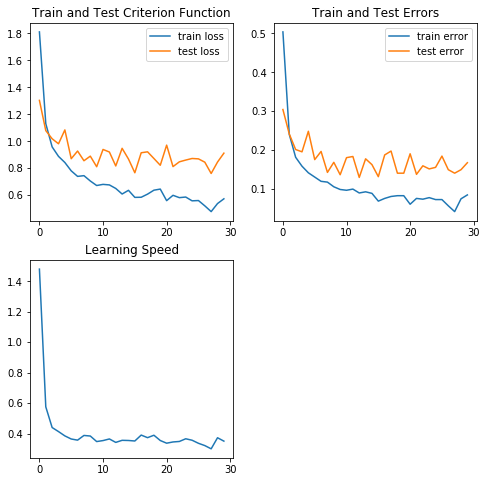

In [30]:
plot_history(history, epochs)

##### 3 hidden layers

In [46]:
## 3 hidden layers

learning_rate = 0.01
epochs = 30
lamda = 0.001  

model = Sequential()
model.add(Dense(30,'sigmoid', input_shape = (X_train.shape[1],), kernel_regularizer= regularizers.l2(lamda))) 
model.add(Dense(30,'sigmoid', kernel_regularizer= regularizers.l2(lamda)))
model.add(Dense(30,'sigmoid', kernel_regularizer= regularizers.l2(lamda))) 
model.add(Dense(10, 'softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate), loss=losses.SparseCategoricalCrossentropy(),
              metrics = ['sparse_categorical_accuracy'])

In [47]:
history = train(model, epochs)


Epoch 1:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 5ms/step - loss: 2.3143 - sparse_categorical_accuracy: 0.1620 - val_loss: 2.0234 - val_sparse_categorical_accuracy: 0.3350
Epoch 2:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 1.8251 - sparse_categorical_accuracy: 0.3800 - val_loss: 1.6900 - val_sparse_categorical_accuracy: 0.4410
Epoch 3:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 1.5741 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.6419 - val_sparse_categorical_accuracy: 0.4870
Epoch 4:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================] - 0s 2ms/step - loss: 1.4797 - sparse_categorical_accuracy: 0.5450 - val_loss: 1.5010 - val_sparse_categorical_accuracy: 0.5770
Epoch 5:
Train for 100.0 steps, validate for 100.0 steps
100/100 [==============================

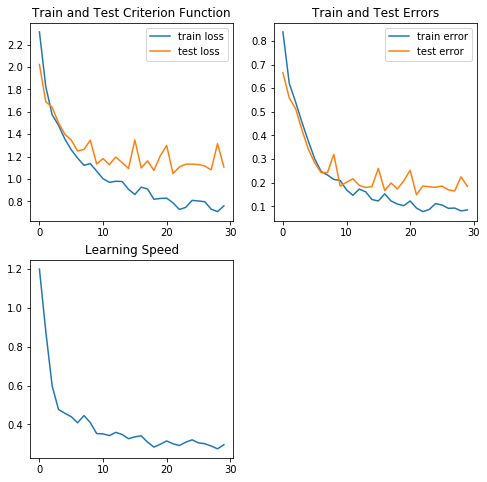

In [48]:
plot_history(history, epochs)

### Part 2c

In [49]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

In [50]:
X_train_2d = X_train.reshape(1000, IMG_WIDTH, IMG_HEIGHT, 1)
X_test_2d = X_test.reshape(1000, IMG_WIDTH, IMG_HEIGHT, 1)

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_img_generator = ImageDataGenerator(rescale=1./255, rotation_range=3, 
                                         width_shift_range = 3./28, 
                                         height_shift_range = 3./28)
train_img_generator.fit(X_train_2d)

train_gen = train_img_generator.flow(X_train_2d, y_train, batch_size = batch_size)



test_img_generator  = ImageDataGenerator(rescale=1./255, rotation_range=3,
                                         width_shift_range = 3./28, 
                                         height_shift_range = 3./28)

test_img_generator.fit(X_test_2d)

test_gen = test_img_generator.flow(X_test_2d, y_test, batch_size = batch_size)

In [52]:
#cnn with dropout

model = Sequential()
model.add(Conv2D(8, 3, padding = 'valid', activation='relu', input_shape = (IMG_WIDTH, IMG_HEIGHT, 1)))
model.add(Dropout(0.2))
model.add(Conv2D(8, 3,padding = 'valid', activation = 'relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))


In [53]:
model.compile(optimizer='adam', loss= tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [54]:
steps_per_epoch = np.ceil(X_train_2d.shape[0]/batch_size)

history = model.fit(train_gen, epochs=50, steps_per_epoch= steps_per_epoch,
                    validation_data = test_gen, validation_steps = steps_per_epoch)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100.0 steps, validate for 100.0 steps
Epoch 1/50
100/100 [==============================] - 1s 12ms/step - loss: 1.8623 - accuracy: 0.3440 - val_loss: 1.3273 - val_accuracy: 0.5750
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 1.2650 - accuracy: 0.5890 - val_loss: 1.0828 - val_accuracy: 0.6340
Epoch 3/50
100/100 [==============================] - 1s 11ms/step - loss: 0.9444 - accuracy: 0.6800 - val_loss: 0.8236 - val_accuracy: 0.7400
Epoch 4/50
100/100 [==============================] - 1s 8ms/step - loss: 0.7202 - accuracy: 0.7820 - val_loss: 0.6700 - val_accuracy: 0.8020
Epoch 5/50
100/100 [==============================] - 2s 16ms/step - loss: 0.6728 - accuracy: 0.7980 - val_loss: 0.5395 - val_accuracy: 0.8480
Epoch 6/50
100/100 [==============================] - 1s 12ms/step - loss: 0.5932 - accuracy: 0.8100 - val_loss: 0.5329 - val_accuracy: 0.8300
Epoch 7/50
100/100 [==========================

Text(0.5, 1.0, 'Train and Test Accuracy')

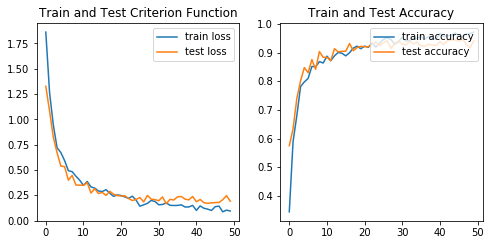

In [55]:
epochs_range = range(50)
plt.figure(figsize = (8,8))

plt.subplot(2,2,1)
plt.plot(epochs_range, history.history['loss'], label = 'train loss')
plt.plot(epochs_range, history.history['val_loss'], label = 'test loss')
plt.legend(loc = 'upper right')
plt.title('Train and Test Criterion Function')

plt.subplot(2,2,2)
plt.plot(epochs_range, history.history['accuracy'], label = 'train accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label = 'test accuracy')
plt.legend(loc = 'upper right')
plt.title('Train and Test Accuracy')

### References



*   https://www.tensorflow.org/tutorials/quickstart/advanced
*   https://www.tensorflow.org/tutorials/images/classification
*   https://www.tensorflow.org/tutorials/images/cnn
*   https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/




